# Natural Language Processing on Health Tweets

### Importing Packages

In [1]:
import codecs
import glob
import os
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import nltk
import gensim.models.word2vec as w2v2
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import gensim.models.word2vec as w2v
import re
import numpy as np
import pandas as pd
from pprint import pprint

nlp = spacy.load("en_core_web_sm")# load model package "en_core_web_sm"

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
from matplotlib import rcParams
%pylab inline
import warnings
warnings.filterwarnings("ignore")
# import gsdmm
# from gsdmm import MovieGroupProcess
from nltk.stem.snowball import SnowballStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
#from imblearn.over_sampling import SMOTE



Populating the interactive namespace from numpy and matplotlib


### Reading Tweet files
##### Downloaded the data from the UCI  https://archive.ics.uci.edu/ml/datasets/Health+News+in+Twitter

In [2]:
Health_tweets= sorted(glob.glob("Health-Tweets/*.txt"))
tweet = u""
for i in Health_tweets:
    with codecs.open(i, "r",encoding="utf8", errors='ignore') as book_file:
        tweet += book_file.read()
print("Reading Complete")
    
#Creating Dataframe

df=pd.DataFrame(tweet.split('\r\n'),columns=["Tweet"])
print("Dataframe with Tweets created")

Reading Complete
Dataframe with Tweets created


In [3]:
df.head()

,Tweet
0,586266658731388929|Thu Apr 09 20:37:18 +0000 2...
1,586260160462589954|Thu Apr 09 20:11:29 +0000 2...
2,586238751334125569|Thu Apr 09 18:46:24 +0000 2...
3,586181878635298817|Thu Apr 09 15:00:25 +0000 2...
4,586159308745920512|Thu Apr 09 13:30:44 +0000 2...


### Data Cleaning

In [4]:
#removing hyperlinks from tweets
df['Tweet_Cleaned']=df['Tweet'].apply(lambda x: re.sub(r'http\S+', '', x))

#removing Timestamp
df['Tweet_Cleaned']=df['Tweet_Cleaned'].apply(lambda x: x[x.rfind('|')+1:])

#removing Special Characters
df['Tweet_Cleaned']=df['Tweet_Cleaned'].apply(lambda x: re.sub(r'\W', ' ', x))

#converting into lowercase
df['Tweet_Cleaned']=df['Tweet_Cleaned'].apply(lambda x: x.lower())

#removig stopwords
df['Tweet_Cleaned']=df['Tweet_Cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in STOP_WORDS]))

#removing "rt & amp"
df['Tweet_Cleaned']=df['Tweet_Cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in ['rt','amp']]))

#removing single character string
df['Tweet_Cleaned']=df['Tweet_Cleaned'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))

df.head()

,Tweet,Tweet_Cleaned
0,586266658731388929|Thu Apr 09 20:37:18 +0000 2...,tougher vaccine law calif clears hurdle
1,586260160462589954|Thu Apr 09 20:11:29 +0000 2...,new sort extracurricular activity seeing patients
2,586238751334125569|Thu Apr 09 18:46:24 +0000 2...,houston firefighters tool disposal answering c...
3,586181878635298817|Thu Apr 09 15:00:25 +0000 2...,montana expand medicaid program moderates revi...
4,586159308745920512|Thu Apr 09 13:30:44 +0000 2...,rand paul campaign day abortion budget


### Tokenizing tweets

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
data_words = list(sent_to_words(df['Tweet_Cleaned']))
print("Before Tokenize:",df['Tweet_Cleaned'][0])
print("After Tokenize:",data_words[0])

Before Tokenize: tougher vaccine law calif clears hurdle
After Tokenize: ['tougher', 'vaccine', 'law', 'calif', 'clears', 'hurdle']


### Most commonly used words in tweets

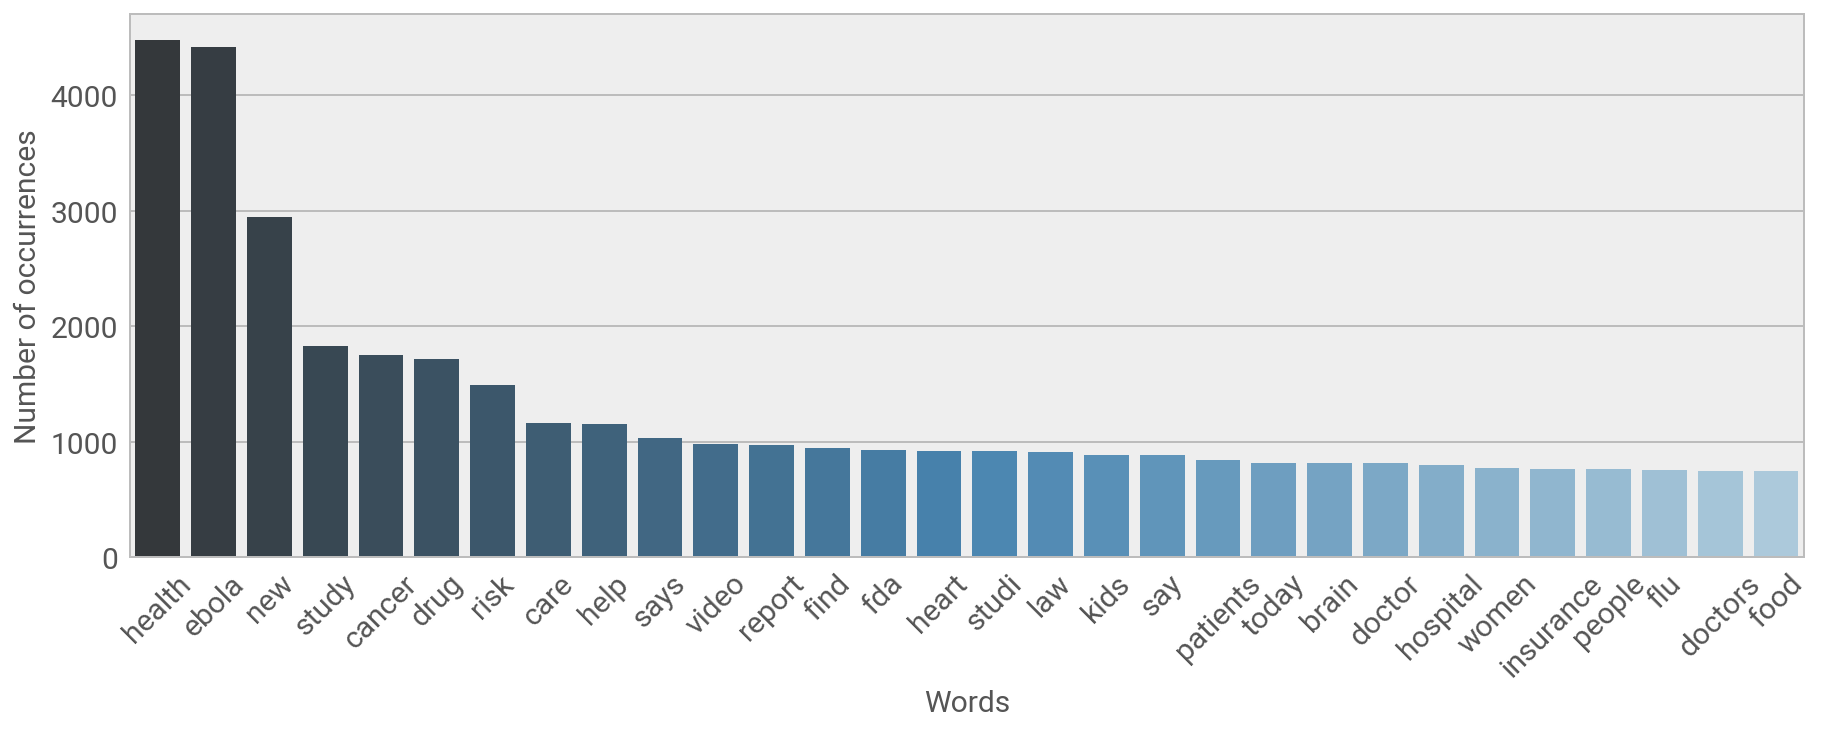

In [6]:
def most_common(top):
    a=pd.Series(' '.join(df['Tweet_Cleaned']).lower().split()).value_counts()[:top]
    a=pd.DataFrame({'word':a.index, 'count':a.values})
    plt.figure(figsize=(15,5))
    ax = sns.barplot(data=a, x= "word", y = "count",palette="Blues_d")
    #ax.set(ylabel = 'Count')
    plt.xlabel("Words",size=15)
    plt.ylabel("Number of occurrences",size=15)
    plt.xticks(rotation=45)
    plt.tick_params(labelsize=15)
    plt.show()
most_common(30)

### Word2Vec Model

In [7]:
#creating word embeddings
num_features = 300
min_word_count = 10
context_size = 7
seed = 1
model = w2v.Word2Vec(
    sg=1,
    seed=seed,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
)
model.build_vocab(data_words)
print("Word2Vec vocabulary length:", len(model.wv.vocab))
model.train(data_words,total_examples=model.corpus_count,epochs=5)

Word2Vec vocabulary length: 4951


(1311837, 1630155)

In [8]:
##Visualing the embeddings
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
all_word_vectors_matrix = model.wv.syn0
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)
# Creating a Dataframe with Words and 
Words_2D_Space = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[model.wv.vocab[word].index])
            for word in model.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)
def plot_region(x_bounds, y_bounds):
    slice = Words_2D_Space[
        (x_bounds[0] <= Words_2D_Space.x) &
        (Words_2D_Space.x <= x_bounds[1]) & 
        (y_bounds[0] <= Words_2D_Space.y) &
        (Words_2D_Space.y <= y_bounds[1])
    ]
    ax = slice.plot.scatter("x", "y", s=35, figsize=(15, 5))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

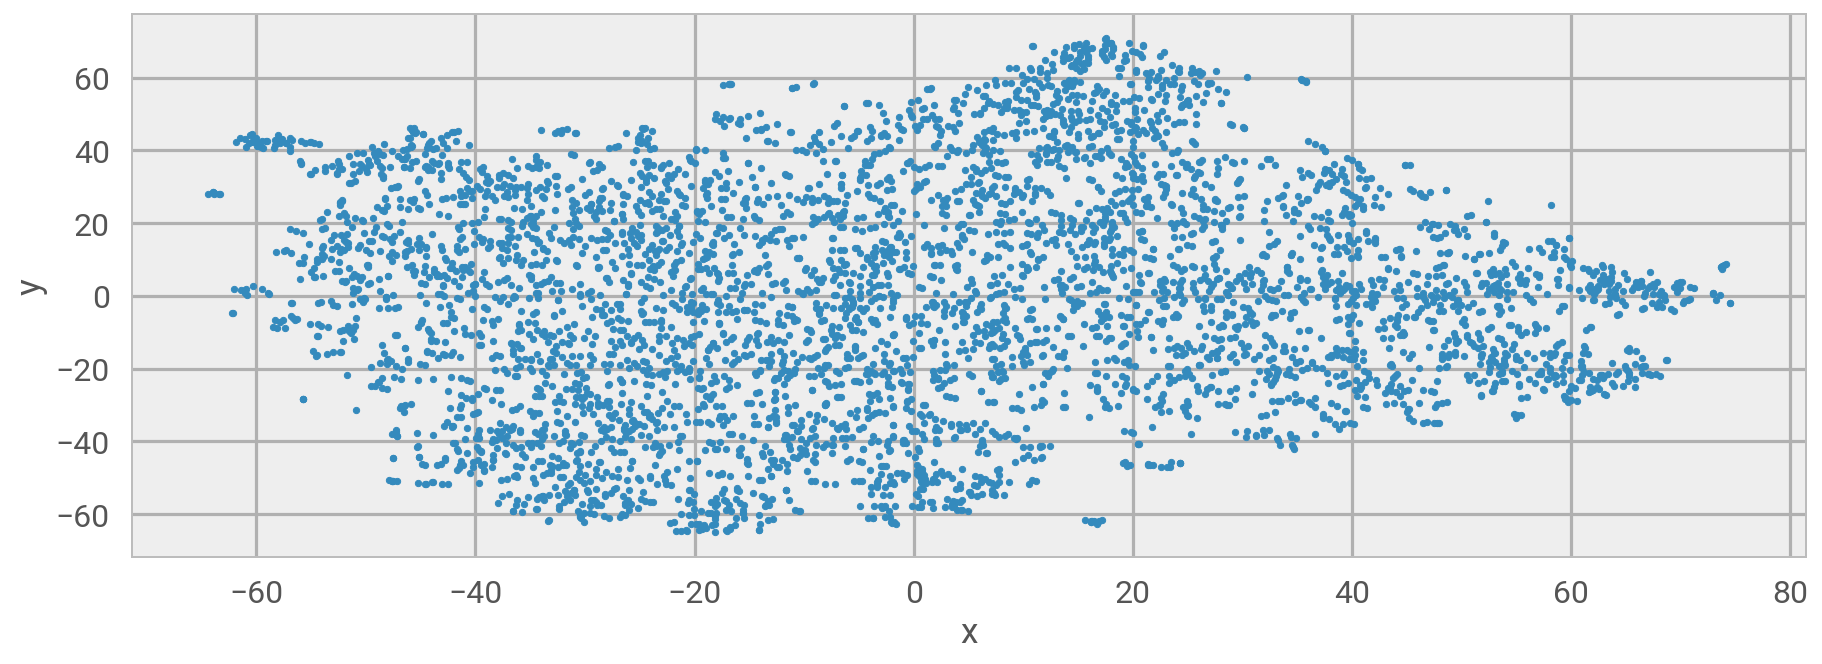

In [9]:
sns.set_context("poster")
Words_2D_Space.plot.scatter("x", "y", s=10, figsize=(15, 5))

In [10]:
Words_2D_Space[Words_2D_Space.word=="vaccine"]

,word,x,y
1,vaccine,55.467487,-28.138138


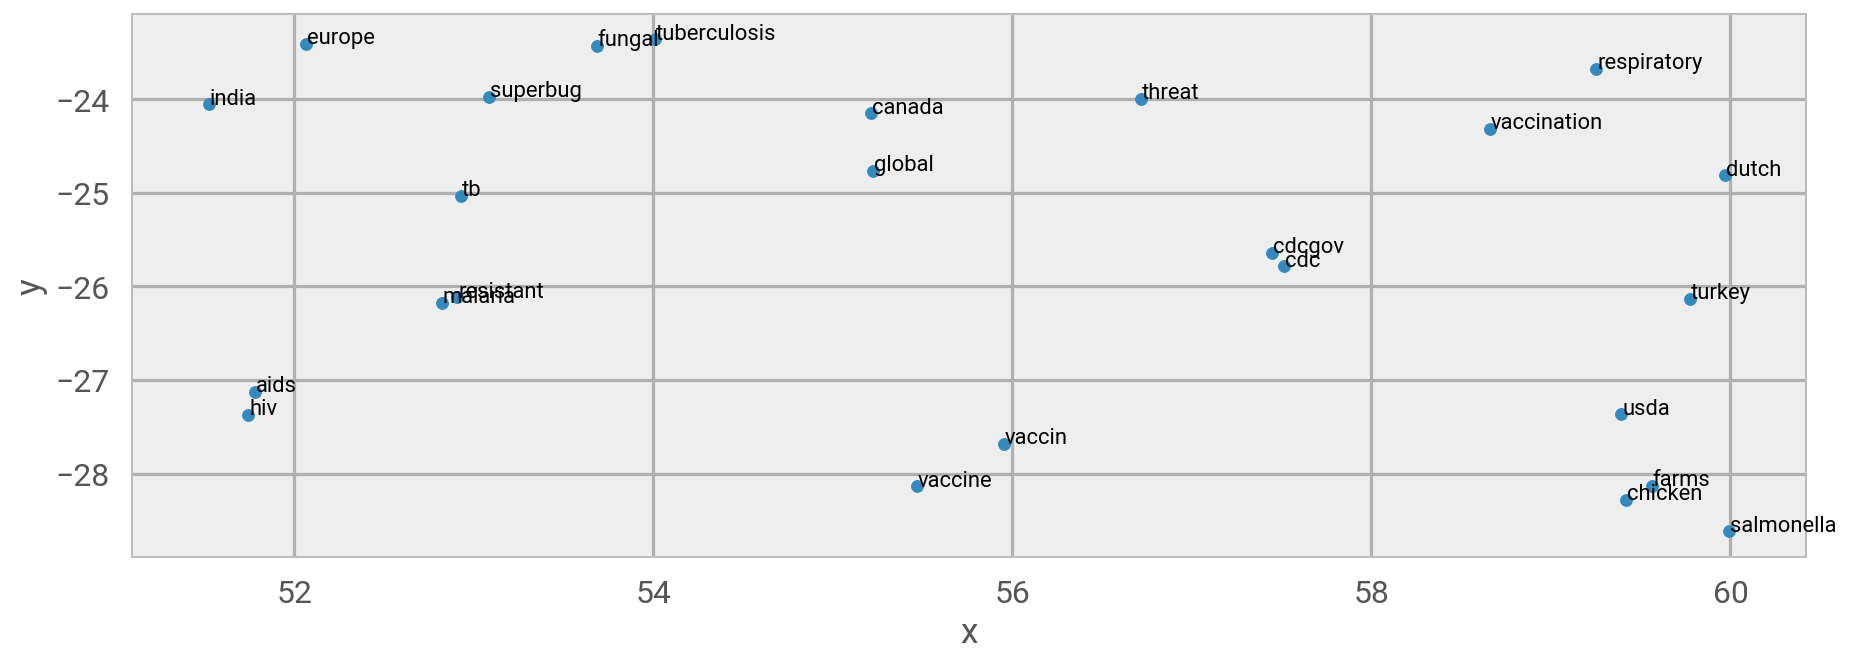

In [15]:
plot_region(x_bounds=(50, 60), y_bounds=(-29, -23))

In [16]:
#Now using Word2Vec model to see which words are used with most common words
for i in ["health","ebola","drug","fda"]:
    print("Most similar word for", i.upper())
    print("\n")
    print(model.most_similar(i))
    print("\n")

Most similar word for HEALTH


[('healthcare', 0.7142654061317444), ('obama', 0.6559319496154785), ('affordable', 0.6451594829559326), ('small', 0.6422703266143799), ('philgalewitz', 0.6396865248680115), ('provide', 0.6380597352981567), ('aca', 0.6357473134994507), ('act', 0.635206937789917), ('employers', 0.628527045249939), ('illness', 0.6183738708496094)]


Most similar word for EBOLA


[('liberia', 0.8531898260116577), ('sierra', 0.8080457448959351), ('leone', 0.8051755428314209), ('africa', 0.790830671787262), ('west', 0.7731906175613403), ('guinea', 0.7532203793525696), ('nurse', 0.7517105937004089), ('dallas', 0.747846245765686), ('ebolaqanda', 0.7096258401870728), ('msf', 0.7062109708786011)]


Most similar word for DRUG


[('drugs', 0.8616975545883179), ('roche', 0.7855185270309448), ('novartis', 0.7790189981460571), ('bristol', 0.7710151672363281), ('merck', 0.7707940936088562), ('pfizer', 0.7650500535964966), ('approves', 0.7599920034408569), ('lilly', 0.7573618292808533), (

### LDA Topic Modelling

In [6]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
        
    return texts_out
  
#Lemmatization of words
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB'])
data_lemmatized=list(sent_to_words(data_lemmatized))
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]
#LDA mallet model
#mallet_path = 'mallet-2.0.8/mallet-2.0.8/bin/mallet'

In [11]:
#Finding Optimum Topics within model
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=11, step=1)

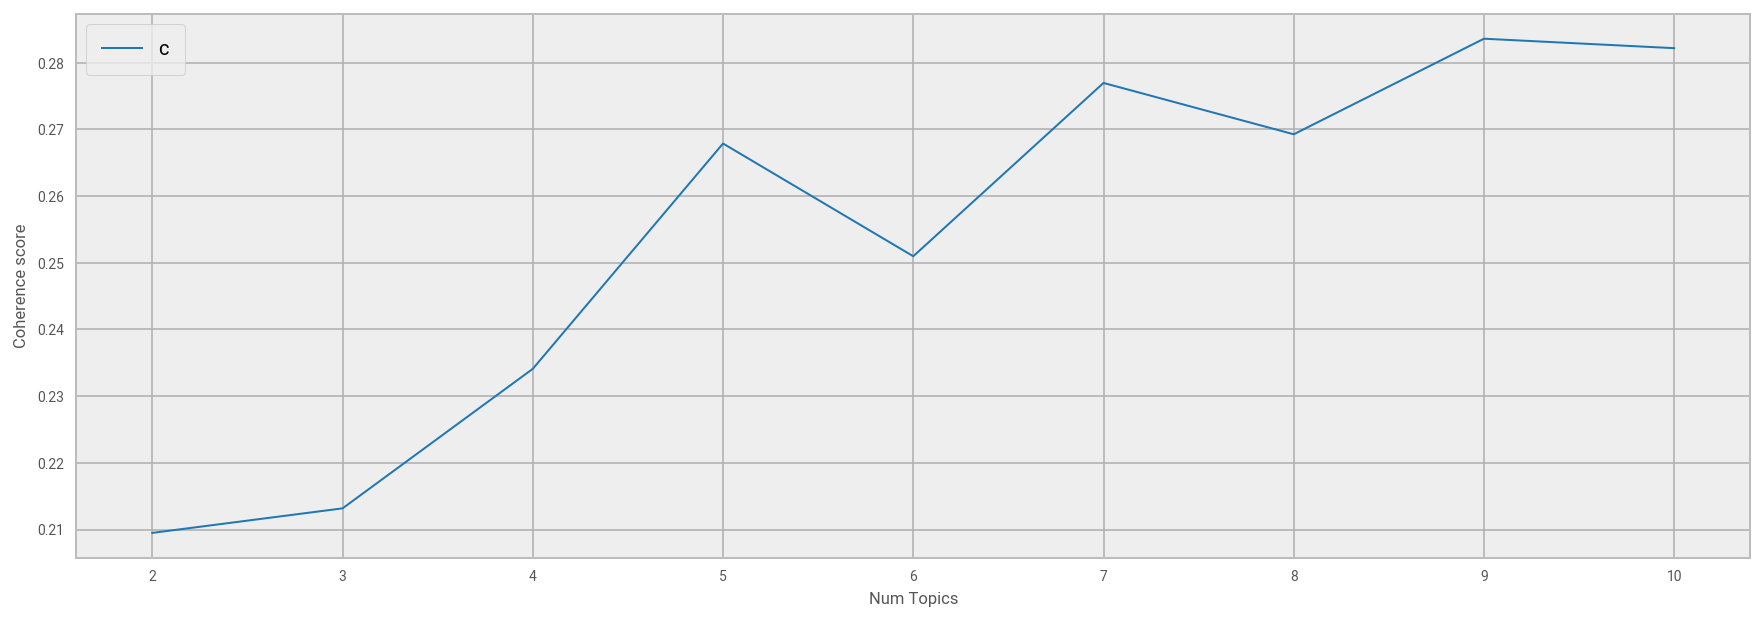

In [12]:
limit=11; start=2; step=1;
x = range(start, limit, step)
plt.figure(figsize=(15,5))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [7]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 9, id2word=id2word, passes=15)

In [8]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, id2word, sort_topics=False)
pyLDAvis.display(lda_display)

E:\Anaconda\lib\site-packages\past\builtins\misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


### GSDMM (Short text topic modelling)

In [36]:
# Use English stemmer.
stemmer = SnowballStemmer("english")
df['data_words']=data_words
df['stemmed'] = df['data_words'].apply(lambda x: [stemmer.stem(y) for y in x]) 
docs = df['stemmed'].tolist()
vocab = set(x for doc in docs for x in doc)
n_terms = len(vocab)
mgp = MovieGroupProcess(K=9, alpha=1, beta=0.05, n_iters=30)
y = mgp.fit(docs, n_terms)
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topics :', doc_count)
print('*'*20)
top_index = doc_count.argsort()[-10:][::-1]
print('Most important clusters (by number of docs inside):', top_index)
print('*'*20)

In stage 0: transferred 39171 clusters with 9 clusters populated
In stage 1: transferred 28079 clusters with 9 clusters populated
In stage 2: transferred 20188 clusters with 9 clusters populated
In stage 3: transferred 15356 clusters with 9 clusters populated
In stage 4: transferred 12642 clusters with 9 clusters populated
In stage 5: transferred 10804 clusters with 9 clusters populated
In stage 6: transferred 9479 clusters with 9 clusters populated
In stage 7: transferred 8588 clusters with 9 clusters populated
In stage 8: transferred 8011 clusters with 9 clusters populated
In stage 9: transferred 7658 clusters with 9 clusters populated
In stage 10: transferred 7450 clusters with 9 clusters populated
In stage 11: transferred 7294 clusters with 9 clusters populated
In stage 12: transferred 7129 clusters with 9 clusters populated
In stage 13: transferred 7005 clusters with 9 clusters populated
In stage 14: transferred 7042 clusters with 9 clusters populated
In stage 15: transferred 6853

In [38]:
from collections import Counter
d={}
for topic,i in enumerate(mgp.cluster_word_distribution):
    a=collections.OrderedDict(dict(Counter(i).most_common(20)))
    d[topic]=a
for k,l in d.items():
    print("Top words for Topic",k)
    l=l.items()
    print([i[0] for i in l])
    print("\n")

Top words for Topic 0
['ebola', 'patient', 'hospit', 'say', 'case', 'health', 'africa', 'outbreak', 'liberia', 'new', 'leon', 'worker', 'sierra', 'nurs', 'west', 'virus', 'doctor', 'test', 'vaccin', 'cdc']


Top words for Topic 1
['health', 'new', 'drug', 'doctor', 'care', 'fda', 'medic', 'hospit', 'nhs', 'rule', 'patient', 'video', 'say', 'food', 'cigarett', 'ban', 'abort', 'report', 'marijuana', 'smoke']


Top words for Topic 2
['health', 'insur', 'obamacar', 'law', 'care', 'report', 'plan', 'exchang', 'state', 'medicar', 'new', 'medicaid', 'hospit', 'coverag', 'today', 'enrol', 'obama', 'cost', 'stefaniei', 'say']


Top words for Topic 3
['flu', 'outbreak', 'case', 'vaccin', 'bird', 'virus', 'say', 'measl', 'recal', 'new', 'death', 'cdc', 'health', 'spread', 'infect', 'diseas', 'report', 'year', 'dead', 'polio']


Top words for Topic 4
['new', 'cancer', 'help', 'old', 'patient', 'age', 'video', 'life', 'doctor', 'babi', 'brain', 'kid', 'die', 'blog', 'year', 'care', 'hospit', 'paren

In [39]:
df["topic"]=df["stemmed"].map(lambda x: mgp.choose_best_label(x))
df.head()

,Tweet,Tweet_Cleaned,data_words,stemmed,topic
0,586266658731388929|Thu Apr 09 20:37:18 +0000 2...,tougher vaccine law calif clears hurdle,"[tougher, vaccine, law, calif, clears, hurdle]","[tougher, vaccin, law, calif, clear, hurdl]","(1, 0.8365033122956107)"
1,586260160462589954|Thu Apr 09 20:11:29 +0000 2...,new sort extracurricular activity seeing patients,"[new, sort, extracurricular, activity, seeing,...","[new, sort, extracurricular, activ, see, patient]","(7, 0.9448971930214315)"
2,586238751334125569|Thu Apr 09 18:46:24 +0000 2...,houston firefighters tool disposal answering c...,"[houston, firefighters, tool, disposal, answer...","[houston, firefight, tool, dispos, answer, cal...","(4, 0.8583132641049116)"
3,586181878635298817|Thu Apr 09 15:00:25 +0000 2...,montana expand medicaid program moderates revi...,"[montana, expand, medicaid, program, moderates...","[montana, expand, medicaid, program, moder, re...","(2, 0.9999948170392098)"
4,586159308745920512|Thu Apr 09 13:30:44 +0000 2...,rand paul campaign day abortion budget,"[rand, paul, campaign, day, abortion, budget]","[rand, paul, campaign, day, abort, budget]","(2, 0.9997554400317762)"


### IBM Tone Analyzer

In [ ]:
import ast
from watson_developer_cloud import ToneAnalyzerV3

tone_analyzer = ToneAnalyzerV3(
    version='2020-06-09',
    iam_apikey='KEY',
    url = 'URL')


tones = []
index = 0
for item in sample_df_2['Tweet_Cleaned']:
    try:
        index = index + 1
        text = item
        tone_analysis = tone_analyzer.tone({'text': text}, content_type='application/json').get_result()
        tones.append(tone_analysis)
    except:
        tones.append(None)
        print ("Method failed with status code ")

sample_df_2["tones"]=tones
sample_df_2['tones'] = sample_df_2.tones.apply(lambda x: x['document_tone'] if x is not None else None)
sample_df_2['tones'] = sample_df_2.tones.apply(lambda x: x['tones']  if x is not None else None)
#df['tones'] = df.tones.apply(lambda x: x[0] if len(x)>0 else [])
sample_df_2.reset_index(inplace=True)

sample_df_2.head()

for i in range(0, len(sample_df_2)):
    if sample_df_2.loc[i, 'tones'] is not None:
        for j in range(0, len(sample_df_2.loc[i, 'tones'])):
            dic = sample_df_2.loc[i, 'tones'][j]
            source = dic['tone_id']
            sample_df_2.loc[i, source] = dic['score']

sample_df_2.head()
tone_df=sample_df_2
for i in ['tentative','analytical','sadness','confident','joy','anger','fear']:
    tone_df[i]=tone_df[i].apply(lambda x: 1 if x>0 else 0)
    
tone_df.head()
tone_df.to_excel("HealthTones_2.xlsx")

In [3]:
df_tone1=pd.read_excel("HealthTones.xlsx")
df_tone2=pd.read_excel("HealthTones_2.xlsx")

In [19]:
df_tones=pd.concat([df_tone1,df_tone2])
df_tones.drop(['Tweet','level_0','tones','index'],1,inplace=True)
df_tones['Tweet_Cleaned'] =df_tones['Tweet_Cleaned'].astype('str')
stemmer = SnowballStemmer("english")
df_tones['Tweet_Cleaned'] = df_tones['Tweet_Cleaned'].apply(lambda x: stemmer.stem(x) )
print("Number of tweets",len(df_tones))
df_tones.head()

Number of tweets 5000


,Tweet_Cleaned,analytical,anger,confident,fear,joy,sadness,tentative
0,poverty behind detroit high child mortality r,0,0,0,0,0,0,0
1,are fish the new fountain of youth,0,0,0,0,1,0,0
2,healthcare quality as important as lowering he...,0,0,0,0,0,0,0
3,hiv second highest killer of south african you...,0,0,0,0,0,1,0
4,with time running out florida medicaid expansi...,0,0,0,0,0,0,1


### Dataset Prepration for modeling

In [25]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_tones, random_state=42, test_size=0.20, shuffle=True)
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
train_text=train['Tweet_Cleaned']
test_text=test['Tweet_Cleaned']
vectorizer.fit(train_text)
vectorizer.fit(test_text)
x_train = vectorizer.transform(train_text)
y_train = train.drop(labels = ['Tweet_Cleaned'], axis=1)
x_test = vectorizer.transform(test_text)
y_test = test.drop(labels = ['Tweet_Cleaned'], axis=1)

### MultiLabel Classification using OneVsRest method

In [26]:
categories=['tentative','analytical','sadness','confident','joy','anger','fear']
# Using pipeline for applying logistic regression and one vs rest classifier
model_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(RandomForestClassifier(criterion="gini",random_state=42), n_jobs=-1)),
            ])
for category in categories:
    print('**Processing',category, 'tweets**')
    #Balancing Classes using SMOTE
    sm = SMOTE(random_state=42)
    x_res, y_res = sm.fit_resample(x_train, train[category])
    # Training Randomforest model on train data
    model_pipeline.fit(x_res, y_res)
    
    # calculating test accuracy
    prediction = model_pipeline.predict(x_test)
    accuracy=accuracy_score(test[category], prediction)
    print("Accuracy is",accuracy)
    print("\n")
    print("Confusion Matrix")
    print(confusion_matrix(test[category], prediction))
    print("\n")
    print("F1 score")
    print(f1_score(test[category], prediction))
    print("\n")
    print("******************************")

**Processing tentative tweets**
Accuracy is 0.927


Confusion Matrix
[[794  44]
 [ 29 133]]


F1 score
0.7846607669616519


******************************
**Processing analytical tweets**
Accuracy is 0.713


Confusion Matrix
[[496 226]
 [ 61 217]]


F1 score
0.6019417475728155


******************************
**Processing sadness tweets**
Accuracy is 0.833


Confusion Matrix
[[731  75]
 [ 92 102]]


F1 score
0.549865229110512


******************************
**Processing confident tweets**
Accuracy is 0.939


Confusion Matrix
[[919  17]
 [ 44  20]]


F1 score
0.396039603960396


******************************
**Processing joy tweets**
Accuracy is 0.704


Confusion Matrix
[[597 268]
 [ 28 107]]


F1 score
0.4196078431372549


******************************
**Processing anger tweets**
Accuracy is 0.969


Confusion Matrix
[[966  25]
 [  6   3]]


F1 score
0.16216216216216214


******************************
**Processing fear tweets**
Accuracy is 0.915


Confusion Matrix
[[838  49]
 [ 36  